In [1]:
from numpy import cos, sin, pi, sqrt, arccos, log
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def simplified_fun(x, y, N):
    #  the boundary is divided into N semgements, 
    #  each segment  end points xp,yp and xm, ym are elements of arrays 
    #  (xp[i],yp[i])__________(barx[i], bary[i])____________(xm[i], ym[i]) 
    #  where barx and bary are coordinates of midpoints
    xp = x[1:]
    yp = y[1:]
    xm = x[:-1]
    ym = y[:-1]
    barx = 0.5 * (xp + xm)
    bary = 0.5 * (yp + ym)
    
    ds = sqrt((xp - xm) ** 2 + (yp - ym) ** 2)
    # compute direction vectors
    directions = np.column_stack([xp - xm, yp - ym])
    # Rotate directions by 90 degrees to obtain normal vectors
    normals = np.column_stack([-directions[:, 1], directions[:, 0]])
    # normalize normal vectors
    norms = np.linalg.norm(normals, axis=1)
    normals_normalized = normals / norms[:, np.newaxis]
    nn1 = normals_normalized[:, 0]
    nn2 = normals_normalized[:, 1]
    nn6 = barx*nn2 - bary*nn1

    hh1 = np.zeros(N)
    hh2 = np.zeros(N)
    hh6 = np.zeros(N)
    dtheta = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            a1 = xm[j] - barx[i]
            a2 = ym[j] - bary[i]
            b1 = xp[j] - barx[i]
            b2 = yp[j] - bary[i]

            # we constrain the argument between -1 and 1 to avoid numerical issues due to round-off errors
            ttemp = np.clip((a1 * b1 + a2 * b2) / sqrt( (a1**2 + a2**2) * (b1**2 + b2**2)), -1, 1)
            dtheta[i, j] = -arccos(ttemp)
            if j - i == 0:
                dtheta[i, j] = -pi # for m=n
            x1g = 0.5 * (xp[j] - xm[j]) / sqrt(3) + barx[j]
            y1g = 0.5 * (yp[j] - ym[j]) / sqrt(3) + bary[j]
            x2g = -0.5 * (xp[j] - xm[j]) / sqrt(3) + barx[j]
            y2g = -0.5 * (yp[j] - ym[j]) / sqrt(3) + bary[j]
            hh0 = log((x1g - barx[i])**2 + (y1g - bary[i])**2)
            hh0 = hh0 + log((x2g - barx[i])**2 + (y2g - bary[i])**2)
            hh0 = hh0 * 0.5
            hh1[i] += hh0 * nn1[j] * ds[j] / 2
            hh2[i] += hh0 * nn2[j] * ds[j] / 2
            hh6[i] += hh0 * nn6[j] * ds[j] / 2

    # the linear system is solved using a standard numpy linear algebra solver
    pdcr1 = (np.linalg.solve(dtheta, hh1))
    pdcr2 = (np.linalg.solve(dtheta, hh2))
    pdcr6 = (np.linalg.solve(dtheta, hh6))

    # finally we compute the added mass coefficents
    a11 = np.sum(pdcr1 * nn1 * ds)
    a22 = np.sum(pdcr2 * nn2 * ds)
    a66 = np.sum(pdcr6 * nn6 * ds)
   
    return pdcr1, [a11, a22, a66]

In [3]:
def solve(figure_type, a, b, number_of_elems):
    theta = np.arange(0, 2 * pi + 2*pi/number_of_elems, 2*pi/number_of_elems)
    bartheta = (theta[1::]+theta[0:-1])*0.5

    if figure_type == 'eclipse':
        r = a*b/sqrt((b*cos(theta))**2 + (a*sin(theta))**2)
        x = r*cos(theta)
        y = r*sin(theta)
    else:
        if figure_type == 'square':
            r = np.arange(0,a, a/number_of_elems)
            r2 = r + a/number_of_elems
            y = np.hstack([r, np.ones(number_of_elems)*a, np.ones(number_of_elems)*a, np.flipud(r2), -r, -np.ones(number_of_elems)*a, -np.ones(number_of_elems)*a, -np.flipud(r2), r[0]])
            x = np.hstack([np.ones(number_of_elems)*a, np.flipud(r2), -r, -np.ones(number_of_elems)*a, -np.ones(number_of_elems)*a, -np.flipud(r2), r, np.ones(number_of_elems)*a, a])
            number_of_elems = 8*number_of_elems
    return simplified_fun(x,y,number_of_elems)
    

In [10]:
def square_m_ij_coeficents(side_len, number_of_elems):
    pdcr, m_coef_numerical =  solve('square', side_len, 0, number_of_elems)
    m_coef_analytical = np.array([4.754 * side_len**2, 4.754 * side_len**2, 0.725 * side_len**3])
    accuracy_arr = m_coef_numerical/m_coef_analytical
    print(m_coef_numerical)
    print(m_coef_analytical )
    print()
    return pdcr, accuracy_arr
    


In [34]:
num_of_elems_list = np.array([100,200,400])
#num_of_elems_list = np.array([100,200])
side_length = 1
accuracy_matrix = np.empty((0, 3))
for n_elem in num_of_elems_list:
    pdcr, accuracy_list = square_m_ij_coeficents(side_length, n_elem)
    accuracy_matrix = np.vstack([accuracy_matrix, accuracy_list])

[4.746987668991857, 4.746987668991856, 0.7202361219187767]
[4.754 4.754 0.725]

[4.750170631936229, 4.75017063193623, 0.7222173679023862]
[4.754 4.754 0.725]

[4.751878630397528, 4.751878630397528, 0.723315020469893]
[4.754 4.754 0.725]



In [27]:
def plot_accuracy(y_label_text, accuracy_list, resolution_list):
    plt.title('Added mass coefficent accuracy ratio as a function of the inverse of resolution', pad = 20)
    _ = plt.plot(resolution_list, accuracy_list,  '.r', markersize=10, label = 'analytical solution')
    plt.gca().set_aspect('equal'
    plt.xlabel('1/N')
    plt.ylabel(y_label_text, rotation='vertical', labelpad=30)
    plt.grid(True)

In [35]:
accuracy_matrix

array([[0.99852496, 0.99852496, 0.99342913],
       [0.9991945 , 0.9991945 , 0.99616189],
       [0.99955377, 0.99955377, 0.99767589]])

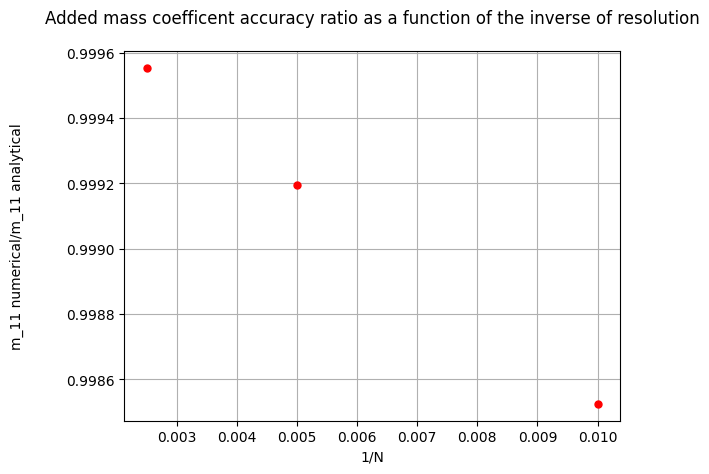

In [36]:
m11_accuracy = accuracy_matrix[:,1]
plot_accuracy("m_11 numerical/m_11 analytical", m11_accuracy, 1/num_of_elems_list)

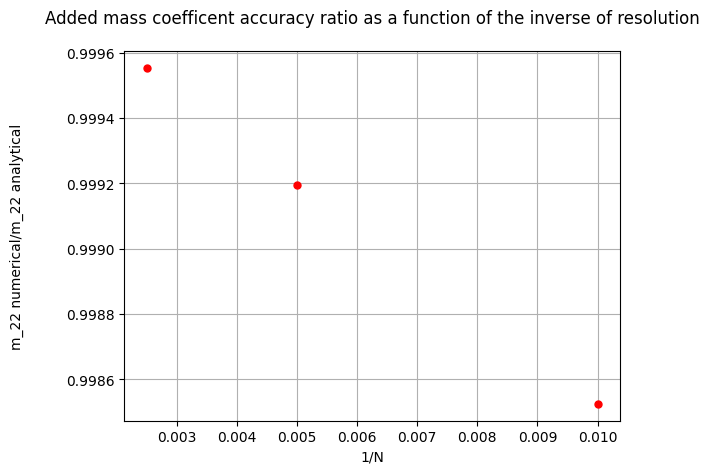

In [37]:
m22_accuracy = accuracy_matrix[:,1]
plot_accuracy("m_22 numerical/m_22 analytical", m22_accuracy, 1/num_of_elems_list)

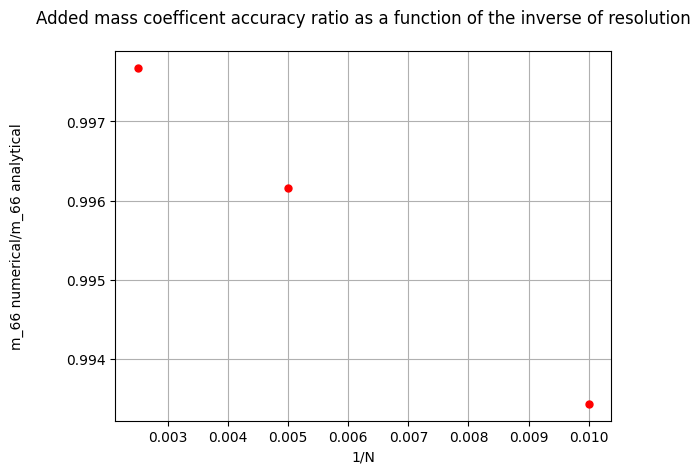

In [38]:
m66_accuracy = accuracy_matrix[:,2]
plot_accuracy("m_66 numerical/m_66 analytical", m66_accuracy, 1/num_of_elems_list)

In [5]:
square_m_ij_coeficents(1, 10)

[4.754 4.754 0.725]
[4.705414331334932, 4.705414331334931, 0.6957712981788484]

